# Predicting bike usage: A worked example for part 3 activity

This is the worked example 'solution' for the part 3 activity. Please try out the activity before you review this notebook!


## Import the libraries we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold

# Feature selection using Recursive Feature Elimimation
from sklearn.feature_selection import RFE

# Sklearn regression algorithms
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Sklearn regression model evaluation functions
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

Define some useful functions 

In [2]:
def linearRegressionSummary(model, column_names):
    '''Show a summary of the trained linear regression model'''

    # Plot the coeffients as bars
    fig = plt.figure(figsize=(8,len(column_names)/3))
    fig.suptitle('Linear Regression Coefficients', fontsize=16)
    rects = plt.barh(column_names, model.coef_,color="lightblue")

    # Annotate the bars with the coefficient values
    for rect in rects:
        width = round(rect.get_width(),4)
        plt.gca().annotate('  {}  '.format(width),
                    xy=(0, rect.get_y()),
                    xytext=(0,2),  
                    textcoords="offset points",  
                    ha='left' if width<0 else 'right', va='bottom')        
    plt.show()
    
def score(model, X, y):
    """Get the model prediction scores using the provided input and target features"""
    
    predictions = model.predict(X)
    print("    R2", r2_score(y, predictions))     
    
def correlatedFeatures(dataset, threshold):
    """Function to list features that are correlated
       Adds the first of the correlated pair only (not both)"""
    
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns    


def kFoldCV(X, y, silent=False):
    """Evaluate linear regression with k-fold cross validation"""
    
    model = LinearRegression()
    
    # Create folds
    seed = 2
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    
    # Perform kfold cross validation
    results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    
    # Show results
    if not silent:
        print(type(model).__name__)
        print("kFoldCV:")
        print("    Fold R2 scores:", results)
        print("    Mean R2 score:", results.mean())
        print("    Std R2 score:", results.std())
    
    # Build a model using all the data and return it
    model.fit(X, y)

    return model

## Load and understand the data


In [3]:
# Load data and inspect the first few rows
dataset = pd.read_csv("bike.csv")
dataset.head()

,id,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,registered,cnt
0,12765,winter,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226,654,880
1,12766,winter,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125,670,795
2,12767,winter,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75,1229,1304
3,12768,winter,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67,1454,1521
4,12769,winter,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58,1518,1576


In [4]:
# Confirm the data types
dataset.dtypes

id                            int64
season                       object
year                          int64
holiday                       int64
weekday                       int64
workingday                    int64
weather                      object
temp                        float64
feel_temp                   float64
hum                         float64
windspeed                   float64
promotion_level               int64
promotion_type                int64
promotion_level_external      int64
promotion_type_external       int64
casual                        int64
registered                    int64
cnt                           int64
dtype: object

In [5]:
# Check for nulls
dataset.isnull().mean()

id                          0.0
season                      0.0
year                        0.0
holiday                     0.0
weekday                     0.0
workingday                  0.0
weather                     0.0
temp                        0.0
feel_temp                   0.0
hum                         0.0
windspeed                   0.0
promotion_level             0.0
promotion_type              0.0
promotion_level_external    0.0
promotion_type_external     0.0
casual                      0.0
registered                  0.0
cnt                         0.0
dtype: float64

C:\Users\llewe\Anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2016.0, right=2016.0
  ax.set_xlim(boundaries_list[j])
C:\Users\llewe\Anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=2016.0, top=2016.0
  ax.set_ylim(boundaries_list[i])
C:\Users\llewe\Anaconda3\lib\site-packages\pandas\plotting\_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2016.0, right=2016.0
  ax.set_xlim(boundaries_list[i])


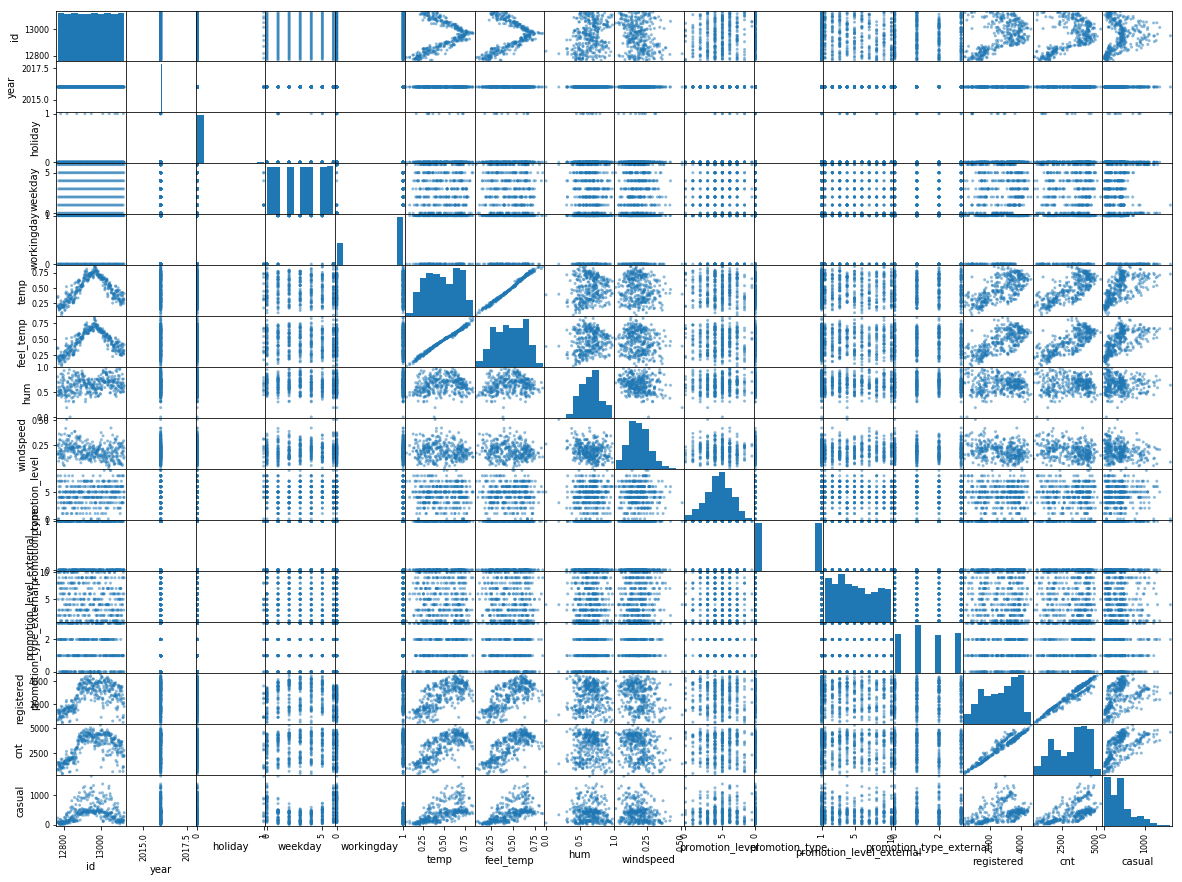

In [6]:
# Plot a scatter matrix
# I like to push the target feature to the bottom, so it is easy to read
df = dataset.drop('casual',axis=1).join(dataset.casual)
pd.plotting.scatter_matrix(df,figsize=(20,15))
plt.show()

## Thoughts?

### Correlations to our target
Looking at the scatter plot above, we see good correlations to our target feature from temp, feel_temp, registered, cnt.  Holiday and weekday also seem to have some relationship.  

### Multicollinearity
The two temperature columns, temp and feel_temp are unsurprisingly highly correlated.  We will probably want to remove one.

Also cnt and registered seem to be correlated.  This is unsurprising, as cnt is the total of casual + registered.  In fact, we should remove BOTH cnt and registered as they will cause "data leakage".  Both columns can only be known if we know the number of bike hires on a particular day, which is what we are trying to predict!  They are, effectively, "inside information" which we can't really know in a real-life prediction situation.

## Feature engineering

We should remove the data leakage features before we go any futher.

In [7]:
# Drop cnt and registered as they will cause data leakage
dataset = dataset.drop(['cnt','registered'], axis=1)

dataset = dataset.drop(['id'], axis=1)
dataset.head()

,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual
0,winter,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226
1,winter,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125
2,winter,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75
3,winter,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67
4,winter,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58


We have a few categorical columns, so we should one-hot-encode these to convert them to numerical columns.

In [8]:
categoricals = ['season','weekday','weather']
dataset = pd.get_dummies(dataset, columns=categoricals) #, drop_first=True)
dataset.head()

,year,holiday,workingday,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cloud,weather_fair,weather_rain
0,2016,0,0,0.344167,0.363625,0.805833,0.160446,7,1,2,...,0,0,0,0,0,0,1,1,0,0
1,2016,0,0,0.363478,0.353739,0.696087,0.248539,8,1,8,...,1,0,0,0,0,0,0,1,0,0
2,2016,0,1,0.196364,0.189405,0.437273,0.248309,3,1,10,...,0,1,0,0,0,0,0,0,1,0
3,2016,0,1,0.200000,0.212122,0.590435,0.160296,0,1,8,...,0,0,1,0,0,0,0,0,1,0
4,2016,0,1,0.226957,0.229270,0.436957,0.186900,2,0,5,...,0,0,0,1,0,0,0,0,1,0


## Split into X and y

In [9]:
# Our target feature
y = dataset.casual

# Our input features
X = dataset.drop(['casual'], axis=1)

## Rescale

In [10]:
# Rescale the input features
scaler = MinMaxScaler(feature_range=(0,1))
X_ = scaler.fit_transform(X)
X = pd.DataFrame(X_, columns=X.columns)

C:\Users\llewe\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Simple linear regression

Build a linear regression model as a baseline, so we can see the effect of any improvements we make later.

In [11]:
# Split into train (2/3) and test (1/3) sets
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


Train set:
    R2 0.798265855369959
Test set:
    R2 0.7444590452036944


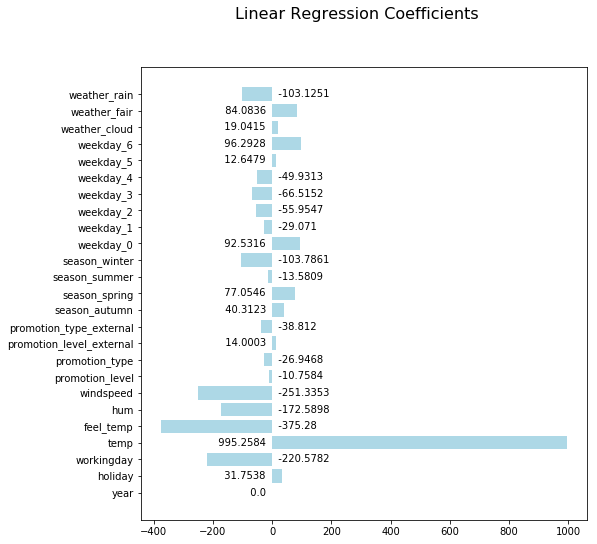

In [12]:
# Build and evaluate a linear regression model 

# Create model
model = LinearRegression()

# Fit model
model.fit(X_train, y_train)
print("Train set:")
score(model, X_train, y_train)

# Evaluate
print("Test set:")
score(model, X_test, y_test)

# Summary
linearRegressionSummary(model, X_train.columns)

## Resampling with k-fold cross-validation

Evaluate linear regression with 10-fold cross validation.

LinearRegression
kFoldCV:
    Fold R2 scores: [0.70089783 0.75747131 0.7560967  0.57715067 0.81138158 0.76612513
 0.84251758 0.74793549 0.78256577 0.7103859 ]
    Mean R2 score: 0.7452527975884815
    Std R2 score: 0.06883083123933935
Test set
    R2 0.7444590452036944


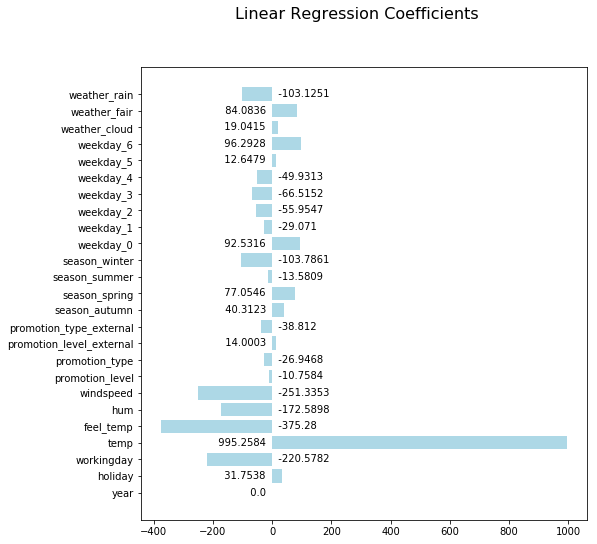

In [13]:
# Evaluate the linear regression model using 10-fold cross validation
model = kFoldCV(X_train, y_train)

# I will evaluate using the test set
print("Test set")
score(model, X_test, y_test)

linearRegressionSummary(model, X_train.columns)


The R-squared scores are pretty consistent.  We can be more confident in it due to the evaluation against 10 folds.

## Feature selection

### Remove low variance features
Identify some low variance features, those with variance less than 0.1 and remove them.

In [21]:
# Check the shape before we remove anything
X_test.shape

(121, 25)

In [14]:
X.var()

year                        0.000000
holiday                     0.026720
workingday                  0.216393
temp                        0.057592
feel_temp                   0.049115
hum                         0.023394
windspeed                   0.025126
promotion_level             0.044400
promotion_type              0.250685
promotion_level_external    0.104256
promotion_type_external     0.134599
season_autumn               0.187671
season_spring               0.189041
season_summer               0.189041
season_winter               0.186286
weekday_0                   0.122505
weekday_1                   0.122505
weekday_2                   0.122505
weekday_3                   0.122505
weekday_4                   0.122505
weekday_5                   0.122505
weekday_6                   0.124462
weather_cloud               0.224928
weather_fair                0.236444
weather_rain                0.039515
dtype: float64

Try removing low variance features using VarianceThreshold

In [15]:
sel = VarianceThreshold(threshold=(0.01))
sel.fit(X_train)

selected_features = list(X_train.columns[sel.get_support()])
print("Feature selection", sel.get_support())
print("Selected features:", selected_features)
print("Removed features:", list(X_train.columns[~sel.get_support()]))

Feature selection [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
Selected features: ['holiday', 'workingday', 'temp', 'feel_temp', 'hum', 'windspeed', 'promotion_level', 'promotion_type', 'promotion_level_external', 'promotion_type_external', 'season_autumn', 'season_spring', 'season_summer', 'season_winter', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weather_cloud', 'weather_fair', 'weather_rain']
Removed features: ['year']


In [16]:
# Transform (remove low variance features)
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [17]:
# Turn back into a dataframe
X_train = pd.DataFrame(X_train, columns=selected_features)
X_test = pd.DataFrame(X_test, columns=selected_features)

In [18]:
# Confirm the new shape
X_train.shape

(244, 24)

### Correlated features
Remove highly correlated features

In [19]:
# Get a set of correlated features, based on threshold correlation of 0.85
cf = correlatedFeatures(X_train, 0.85)
cf

{'feel_temp', 'weather_fair'}

In [20]:
# Remove the correlated features
X_train = X_train.drop(cf, axis=1)
X_test = X_test.drop(cf, axis=1)

In [21]:
# Confirm the new shape
X_train.shape

(244, 22)

## Apply RFE


Systematically determine number of features to keep

In [23]:
# Build models using from 1 to n-1 features
for i in range(1,X_train.shape[1]-1):
    print("\nRFE ", i, end="\t")
    # Create a model
    model = LinearRegression()

    # Select the best features according to RFE
    rfe = RFE(model, i)
    rfe.fit(X_train, y_train)

    # Transform (remove features not selected)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Evaluate using k-fold cross-validation
    model = kFoldCV(X_train_rfe, y_train, silent=True)
    predictions = model.predict(X_test_rfe)
    print("R2", r2_score(y_test, predictions)) 


RFE  1	R2 0.3246281329358406

RFE  2	R2 0.7051208652825429

RFE  3	R2 0.7044749355460929

RFE  4	R2 0.726685255555156

RFE  5	R2 0.7416662131598455

RFE  6	R2 0.7411372476279005

RFE  7	R2 0.7406398592660238

RFE  8	R2 0.7433543727611176

RFE  9	R2 0.7425425287943135

RFE  10	R2 0.7440307466805103

RFE  11	R2 0.7496281317033936

RFE  12	R2 0.751704922129742

RFE  13	R2 0.753061428611191

RFE  14	R2 0.7573658737365601

RFE  15	R2 0.7573658737365602

RFE  16	R2 0.7567320347002515

RFE  17	R2 0.7552648268976772

RFE  18	R2 0.7431786086989425

RFE  19	R2 0.7426695168001027

RFE  20	R2 0.742669516800103


The best R-squared is with 15 features.  So let's keep just 15

In [24]:
# Create a model
model = LinearRegression()

# Select the best features according to RFE
rfe = RFE(model, 15)
rfe.fit(X_train, y_train)

selected_features = list(X_train.columns[rfe.support_])
print("Feature selection", rfe.support_)
print("Feature ranking", rfe.ranking_)
print("Selected features:", selected_features)
print("Removed features:", list(X_train.columns[~rfe.support_]))

Feature selection [ True  True  True  True  True False False False False  True  True False
  True  True False  True  True  True False  True  True  True]
Feature ranking [1 1 1 1 1 8 4 5 3 1 1 7 1 1 2 1 1 1 6 1 1 1]
Selected features: ['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_autumn', 'season_spring', 'season_winter', 'weekday_0', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_6', 'weather_cloud', 'weather_rain']
Removed features: ['promotion_level', 'promotion_type', 'promotion_level_external', 'promotion_type_external', 'season_summer', 'weekday_1', 'weekday_5']


In [25]:
# Transform (remove features not selected)
X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)

## Evaluate a model with the features removed
Now that we have removed a number of features using low-variance removal, highly correlated feature removal and RFE, build and evaluate a linear regression model with this reduced feature set.

LinearRegression
kFoldCV:
    Fold R2 scores: [0.78161831 0.74877529 0.7520322  0.58639477 0.82789427 0.76167203
 0.82959307 0.75347647 0.7704151  0.75519491]
    Mean R2 score: 0.756706641596798
    Std R2 score: 0.0634955824276521
Test set:
    R2 0.7573658737365602


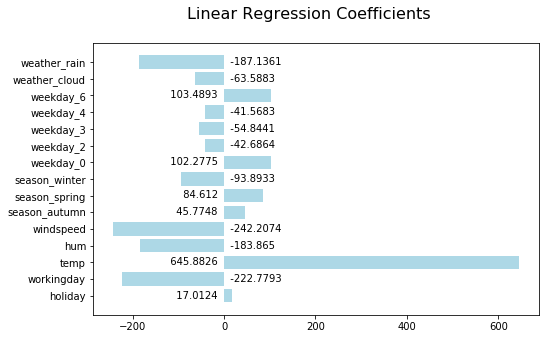

In [26]:
# Build and evaluate a linear regression model with the reduced feature set
model = kFoldCV(X_train, y_train)
print("Test set:")
score(model, X_test, y_test)
linearRegressionSummary(model, selected_features)

 So, we've managed to improve the R-squared score and removed a number of features, making the model faster and easier to interpret.  We've also used cross-validation to give us confidence that the model will perform consistently.

### Use cross-validation version of RFE to determine number of features to keep
Note that there is also a cross-validation version of RFE in Sklearn that does the hard work of finding the optimal number of features to keep:

Optimal number of features : 15


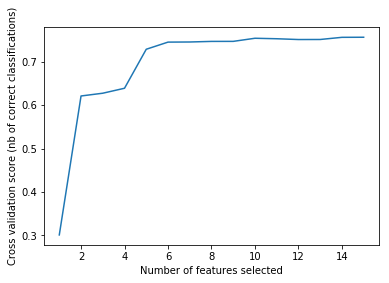

In [27]:
from sklearn.feature_selection import RFECV

from sklearn.model_selection import StratifiedKFold
model = LinearRegression()

seed = 2
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

rfecv = RFECV(estimator=model, step=1, cv=kfold,
              scoring='r2')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Regularization


Build a model using all the original features.  Let's see if regularisation can do some automatic feature selection!

In [30]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV


# Split into train (2/3) and test (1/3) sets
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

#X_train = X_train.drop(['feel_temp', 'weather_fair','year'], axis=1)
#X_test = X_test.drop(['feel_temp', 'weather_fair','year'], axis=1)

# Create 5 folds
seed = 13
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Create model
model = LassoCV(cv=kfold)

#Fit model
model.fit(X_train, y_train)
predictions = model.predict(X_train)
print("Train:", r2_score(y_train, predictions))

# Evaluate
predictions = model.predict(X_test)
print("Test:", r2_score(y_test, predictions))

#model.coef_
print("Alpha:", model.alpha_)

Train: 0.7924336785631494
Test: 0.7289213793594009
Alpha: 1.0343958564482105


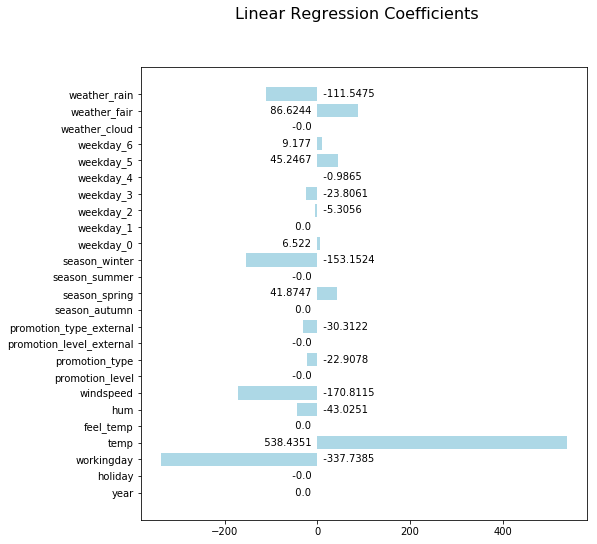

In [29]:
linearRegressionSummary(model, X_train.columns)

We can see that Lasso regression has automatically done a lot of the feature selection for us!

The collinear feel_temp has a zero coefficient.  It has effectively been removed. 

Many of the features have also been removed.

The model is much more interpretable that the baseline linear regression model.
